In [65]:
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn as nn 
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt 

### Dataset

In [66]:
config = {
    "device": "cuda:5",
    "data": {
        "width": 32, 
        "height": 32
    }, 
    "train": {
        "batch_size": 128, 
        "epochs": 100, 
        "num_classes": 100, 
        "dropout": 0.04, 
        "lr": 0.01, 
        "momentum": 0.9, 
        "weight_decay": 0.00001
    }
} 

input_size = 32

In [67]:
class MeanSubstraction(object): 

    def __call__(self, imgs): 
        mean, std = imgs.mean(axis=0), imgs.std(axis=0)
        imgs /= 255.0

        return imgs

In [68]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    MeanSubstraction(),
    transforms.Pad(padding=4), 
    transforms.RandomCrop(config["data"]["width"]), 
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # 50 % 
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
     MeanSubstraction()
])


train_dataset =  CIFAR100(root="../../research/dataset/", download=True, train=True, transform=train_transform)
test_dataset = CIFAR100(root="../../research/dataset/", download=True, train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config["train"]["batch_size"], num_workers=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["train"]["batch_size"], num_workers=4)



Files already downloaded and verified
Files already downloaded and verified


torch.Size([128, 3, 32, 32])


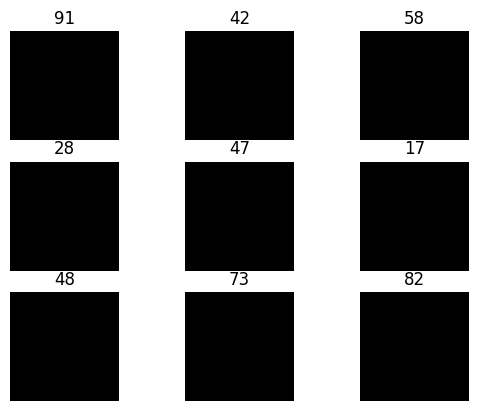

In [69]:
### check data 

for data in train_loader: 
    imgs, labels = data

    print(imgs.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        np_img = torch.permute(imgs[i], (1, 2, 0)).numpy()
        plt.imshow(np_img)
        plt.title(int(labels[i]))
        plt.axis("off")

    break


In [70]:
# model 


class ConvModule(nn.Module): 

    """
    A simple conv -> bn -> relu block 
    """

    def __init__(
        self, 
        in_c, 
        out_c, 
        kernel_size=3,
        stride=1, 
        padding=0, 
        residual=False
    ): 
        super().__init__()
        self.residual = residual
        self.conv = nn.Conv2d(in_c, out_c, kernel_size, stride, padding, bias=False)
        if not residual: 
            self.bn = nn.BatchNorm2d(out_c)
            self.relu = nn.ReLU()


    def forward(self, x): 
        
        out = self.conv(x) 

        if not self.residual:
            out = self.bn(out) 
            out = self.relu(out)

        return out



class DepthWiseSeperableConvolution(nn.Module): 

    def __init__(
        self,
        in_c, 
        out_c, 
        kernel_size=3, 
        stride=1, 
        padding=0 
    ):
        super().__init__()
        self.dwconv = nn.Conv2d(in_c, in_c, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.relu1 = nn.ReLU()

        self.pwconv = nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu2 = nn.ReLU()

    def forward(self, x): 

        x1 = self.dwconv(x) 
        x2 = self.bn1(x1)
        x3 = self.relu1(x2)

        x4 = self.pwconv(x3)
        x5 = self.bn2(x4)
        x6 = self.relu2(x5)
        return x6





class ResnetBlock2n(nn.Module): 
    """
    Simple Resnet layer with 2*2 blocks
    block1 (reduce dimension or not) -> block2 -> block3 -> block4
    """
    def __init__(self, in_c, out_c, reduce_dim=False): 
        super().__init__()

        self.reduce_dim = True
        stride = 2 if reduce_dim else 1 
        self.conv1 = ConvModule(in_c, out_c, 3, stride=stride, padding=1)
        self.conv2 = ConvModule(out_c, out_c, 3, 1, 1) 
        self.conv3 = ConvModule(out_c, out_c, 3, 1, 1) 
        self.conv4 = ConvModule(out_c, out_c, 3, 1, 1) 

        self.shortcut = nn.Conv2d(in_c, out_c, 1, stride=stride, padding=0)

    def forward(self, x): 
        
        identity = self.shortcut(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x2 + identity
        x3 = self.conv3(out)
        x4 = self.conv4(x3)
        out = x4 + out 
        
        return out
        


class ResnetBlock3n(ResnetBlock2n):
    """
    Simple Resnet layer with 3*2 blocks. 
    This class extends the above ResnetBlock2n class
    """
    def __init__(self, in_c, out_c, reduce_dim=False): 
        super().__init__(in_c, out_c, reduce_dim)

        self.conv5 = ConvModule(out_c, out_c, 3, 1, 1, residual=False)
        self.conv6 = ConvModule(out_c, out_c, 3, 1, 1, residual=False) 

    def forward(self, x): 
        x4 = super().forward(x) 
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)

        return x6

In [71]:
class ResNet_18_cifar(nn.Module): 

    def __init__(self, dropout, nb_classes): 

        super().__init__()
        self.block1 = ResnetBlock3n(3, 32)
        self.block2 = ResnetBlock3n(32, 64, reduce_dim=True)
        self.block3 = ResnetBlock3n(64, 128, reduce_dim=True)

        self.pool = nn.AvgPool2d(2, 2)
        self.fc = nn.Linear(128*4*4, nb_classes)
        self.dropout = nn.Dropout(dropout)


    def initialize_weights(self):
        # Loop over the modules in the model
        for module in self.modules():
            # If the module is a linear or convolutional layer
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
                torch.nn.init.kaiming_uniform_(module.weight, leaky_relu="relu")
                torch.nn.init.constant_(module.bias, 0)

    def forward(self, x): 
        bs = x.shape[0]
        x1 = self.block1(x) 
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        out = self.pool(x3) 
        out = out.view(bs, -1)
        out = self.dropout(out)
        out = self.fc(out) 

        return out

        

class ResNet_24_cifar(nn.Module): 

    def __init__(self, dropout, nb_classes, *args, **kwargs): 

        super().__init__(*args, **kwargs)
        self.block1 = ResnetBlock3n(3, 16)
        self.block2 = ResnetBlock3n(16, 32, reduce_dim=True)
        self.block3 = ResnetBlock3n(32, 32, reduce_dim=False)
        self.block4 = ResnetBlock3n(32, 64, reduce_dim=True)

        self.pool = nn.AvgPool2d(2, 2)
        self.fc = nn.Linear(64*4*4, nb_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x): 
        bs = x.shape[0]
        x1 = self.block1(x) 
        x2 = self.block2(x1) 
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        out = self.pool(x4) 
        out = out.view(bs, -1)
        out = self.dropout(out)
        out = self.fc(out) 

        return out


class ResNet_42_cifar(nn.Module): 

    def __init__(self, dropout, nb_classes, *args, **kwargs): 

        super().__init__(*args, **kwargs)
        self.block1 = ResnetBlock3n(3, 32)
        self.block2 = ResnetBlock3n(32, 32, reduce_dim=False)
        self.block3 = ResnetBlock3n(32, 32, reduce_dim=True)
        self.block4 = ResnetBlock3n(32, 64, reduce_dim=False)
        self.block5 = ResnetBlock3n(64, 128, reduce_dim=True)
        self.block6 = ResnetBlock3n(128, 128, reduce_dim=False)

        self.pool = nn.AvgPool2d(2, 2)
        self.fc = nn.Linear(128*4*4, nb_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x): 
        bs = x.shape[0]
        x1 = self.block1(x) 
        x2 = self.block2(x1) 
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x5 = self.block5(x4) 
        x6 = self.block6(x5)
        out = self.pool(x6) 
        out = out.view(bs, -1)
        out = self.dropout(out)
        out = self.fc(out) 

        return out



In [72]:
def accuracy(logits, target):

    preds = nn.functional.softmax(logits) 
    preds = torch.argmax(preds, axis=1) 
    acc = torch.where(preds == target, 1, 0).to(torch.float32).mean()
    return acc
    

### Training Loop 

In [73]:
def train(model, optimizer, criterion, train_loader, epoch, writer=None, scheduler=None): 

    if not writer: 
        print("No writer selected, tensorboard will not be used")
    
    if not scheduler: 
        print("No learning rate scheduler") 

    
    total_loss = 0.0
    total_acc = 0.0
    for i, data in enumerate(train_loader): 
        
        model.zero_grad()
        imgs, labels = data 
        # fix use of global variable 
        imgs = imgs.to(config["device"])
        labels = labels.to(config["device"])

        predictions = model(imgs) 
        loss = criterion(predictions, labels)   
        total_loss += loss.item()
        total_acc += accuracy(predictions, labels)

        loss.backward()
        optimizer.step() 


        if i % 100 == 0 and i != 0: 
            # print(f"[EPOCH {epoch} | {i} / {len(train_loader)}] : cross entropy = {total_loss / 100}")
            grad_sum = 0.0 

            for name, p in model.named_parameters(): 
                norm = p.grad.data.norm(2)
                grad_sum += norm.item() ** 2

            grad_sum = grad_sum ** (1. / 2)
            if writer:
                writer.add_scalar("Train/loss", total_loss / 100, epoch*len(train_loader) + i + 1) 
                writer.add_scalar("Train/gradient_norm", grad_sum, epoch*len(train_loader) + i + 1)
                writer.add_scalar("Train/accuracy", total_acc / 100, epoch*len(train_loader) + i + 1)

            total_loss = 0.0
            total_acc = 0.0


    if scheduler is not None: 
        scheduler.step()




def test(model, criterion, scheduler, test_loader, epoch, writer=None): 

    validation_loss = 0.0 
    total_acc = 0.0
    lenght = len(test_loader)

    for i, data in enumerate(test_loader):

        imgs, labels = data 
        imgs = imgs.to(config["device"])
        labels = labels.to(config["device"])

        predictions = model(imgs) 
        loss = criterion(predictions, labels)   
        validation_loss += loss.item()
        total_acc += accuracy(predictions, labels)
    
    if writer is not None: 
        writer.add_scalar("Test/loss", validation_loss / lenght, epoch*lenght + i + 1)
        writer.add_scalar("Test/accuracy", total_acc / lenght, epoch*lenght + i + 1)
        if scheduler is not None: 
            writer.add_scalar("Train/Learning rate", scheduler.get_last_lr()[0], epoch)
        else: 
            writer.add_scalar("Train/Learning rate", config["train"]["lr"], epoch)

    print(f"Validation at EPOCH={epoch} : ", validation_loss / lenght)
    print("Last learning rate : ", scheduler.get_last_lr()[0])



    

In [74]:
def training_loop(model, optimizer, criterion, train_loader, writer=None, scheduler=None):
    
    print("--- Training ---")
    model.train()
    for epoch in range(config["train"]["epochs"]): 
        train(model, optimizer, criterion, train_loader, epoch, writer, scheduler)
        test(model, criterion, scheduler, test_loader, epoch, writer)
    print("--- Training : DONE ---")


In [75]:
def get_model(): 
    model = ResNet_42_cifar(dropout=config["train"]["dropout"], nb_classes=config["train"]["num_classes"])
    model = model.to(config["device"])
    print("device : ", next(model.parameters()).device)
    # print(summary(model, (3, config["data"]["width"], config["data"]["height"])))
    return model 


def get_optimizer(model): 
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=config["train"]["lr"],
        momentum=config["train"]["momentum"],
        weight_decay=config["train"]["weight_decay"]
    )
    return optimizer 

def get_scheduler(optimizer): 
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 25, 30], gamma=0.1)
    return scheduler


def get_criterion():
    criterion = nn.CrossEntropyLoss()
    return criterion 

In [76]:
def main(): 

    print("--- Loading model ---")
    model = get_model()
    print("--- Loading model : DONE ---") 

    print("--- Loading optimizer ---")
    optimizer = get_optimizer(model)
    print("--- Loading optimizer : DONE ---")

    print("--- Loading scheduler ---")
    scheduler = get_scheduler(optimizer)
    print("--- Loading scheduler : DONE ---")

    print("--- Loading criterion ---")
    criterion = get_criterion() 
    print("--- Load criterion : DONE ---")

    config_name = f"{type(model).__name__}_\
        lr={config['train']['lr']}_\
        bs={config['train']['batch_size']}\
        optimizer={type(optimizer).__name__}\
        scheduler={type(scheduler).__name__}\
        filter_size={(32, 32, 64, 128, 128)}\
        momentum={config['train']['momentum']}\
        cifar100\
        weight_decay={config['train']['weight_decay']}\
    "
    writer = SummaryWriter("runs/" + config_name)

    # train 
    training_loop(model, optimizer, criterion, train_loader, writer, scheduler)


In [77]:
main()

--- Loading model ---
device :  cuda:5
--- Loading model : DONE ---
--- Loading optimizer ---
--- Loading optimizer : DONE ---
--- Loading scheduler ---
--- Loading scheduler : DONE ---
--- Loading criterion ---
--- Load criterion : DONE ---
--- Training ---


/tmp/ipykernel_3331287/1052425669.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = nn.functional.softmax(logits)


Validation at EPOCH=0 :  3.8387832490703726
Last learning rate :  0.01
Validation at EPOCH=1 :  3.365895506701892
Last learning rate :  0.01
Validation at EPOCH=2 :  3.136415049999575
Last learning rate :  0.01
Validation at EPOCH=3 :  2.86370197127137
Last learning rate :  0.01
Validation at EPOCH=4 :  2.664069112343124
Last learning rate :  0.01
Validation at EPOCH=5 :  2.555677311329902
Last learning rate :  0.01
Validation at EPOCH=6 :  2.441776957692979
Last learning rate :  0.01
Validation at EPOCH=7 :  2.291178138950203
Last learning rate :  0.01
Validation at EPOCH=8 :  2.1865739520592027
Last learning rate :  0.01
Validation at EPOCH=9 :  2.142660427697097
Last learning rate :  0.01
Validation at EPOCH=10 :  2.065609440018859
Last learning rate :  0.01
Validation at EPOCH=11 :  2.026406722732737
Last learning rate :  0.01
Validation at EPOCH=12 :  1.9681579221653034
Last learning rate :  0.01
Validation at EPOCH=13 :  1.918784473515764
Last learning rate :  0.01
Validation at 